## Generating PDF and CDF of Salary Data for Electrical Engineers, Computer and Information Research Scientists, and  Miscellaneous Engineers  classified from [the U.S. Bureau of Labor Statistics Occupational Employment Statistics](https://www.bls.gov/oes/current/oes_stru.htm#15-0000)



In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import scipy.optimize
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

### Salary Percentiles for Professionals living in New Mexico

In [2]:
salary_df = pd.read_csv('NM_salary.csv',thousands=',')
salary_df

,Profession,10%,25%,50%,75%,90%
0,Electrical Engineer,67930,87570,111910,137810,162260
1,Computer and Information Research Scientists,88060,109640,132350,132350,162660
2,Other Engineers,63500,87090,114000,142720,163670


In [3]:
average_percentiles = salary_df.mean(axis=0)
average_percentiles

10%     73163.333333
25%     94766.666667
50%    119420.000000
75%    137626.666667
90%    162863.333333
dtype: float64

In [4]:
scipy.stats.norm.cdf(average_percentiles[0], average_percentiles[2], scale=20000)
percentile_array = [0.10, 0.25, 0.5, 0.75, 0.90] # percentiles to optimize over to find variance

In [5]:
def calc_error(std, p_array,percentile_values, mean):
    error = 0
    for i, value in enumerate(p_array):
        error += (p_array[i] - scipy.stats.norm.cdf(percentile_values[i], mean, scale=std))**2
    
    return error


#### Assumptions:  underlying data from all professions is normally distributed with mean salary from all 3 professions of $119,420

We wish to find the standard deviation $\sigma$ of the underlying normal distribution such that the the percentiles salaries at 10,20,50,75,and 90 percentiles are equal to the average percentiles:

$P(X \leq 731,363.33) = 0.10,  \ldots ,P(X \leq 162,863.333) = 0.90$

Let $S=\{ 0.10, 0.25, 0.5, 0.75, 0.90\} $ of percentiles given

Let $V=\{ 73163.33, 94766.66, 119420.00, 137626.66, 162863.330\} $ the salaries at the percentiles above


For all percentiles given, we wish to find $\sigma$ such that it minimzes the following error:
$$\sum_{n=1}^{5} (S_i - F(V_i|\mu, \sigma^2))^2$$	

In [6]:
std_global_optimize = scipy.optimize.fsolve(calc_error, 29_000, args=([0.10, 0.25, 0.5, 0.75, 0.90],average_percentiles, average_percentiles[2]))
std_global_optimize[0]


C:\Users\adamc\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


33533.93291867312

### $\sigma = 33533.9329$
is the standard deviation that minimizes the error above and provides the best fit to the percentile data

In [7]:
x_min, x_large = 25_000, 225_000
x_domain = np.arange(x_min, x_large,1)
n=5000
generate_psuedo_data = np.random.normal(average_percentiles[2],std_global_optimize,n)

salary_bounds=[scipy.stats.norm.ppf(0.15, average_percentiles[2],std_global_optimize)[0], scipy.stats.norm.ppf(0.35, average_percentiles[2],std_global_optimize)[0]]


C:\Users\adamc\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


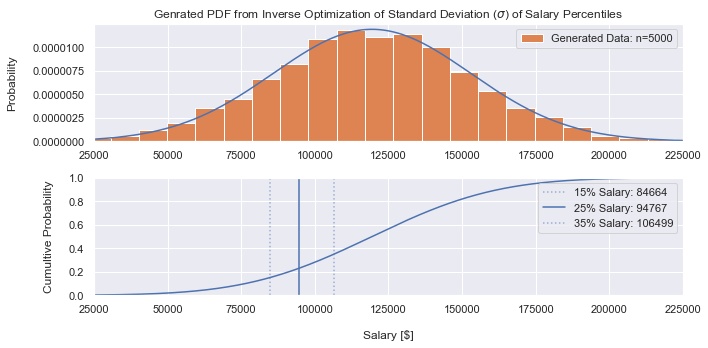

In [11]:
sns.set()
y_probability_pdf = scipy.stats.norm.pdf(x_domain, loc=average_percentiles[2], scale=std_global_optimize )
y_probability_cdf = scipy.stats.norm.cdf(x_domain, loc=average_percentiles[2], scale=std_global_optimize )

fig, (ax1, ax2) = plt.subplots(2, figsize=(10,5))
ax1.plot(x_domain, y_probability_pdf)
(bin_values, _, _) = ax1.hist(generate_psuedo_data, bins=25, stacked=True, density=True,
                              label=f'Generated Data: n={n}')
ax1.set_xlim(x_min, x_large)

ax1.set_ylabel('Probability', labelpad=15)
ax1.set_title(r'Genrated PDF from Inverse Optimization of Standard Deviation ($\sigma$) of Salary Percentiles')
ax1.legend()


ax2.plot(x_domain, y_probability_cdf)

ax2.set_ylabel('Cumultive Probability', labelpad=15)

ax2.axvline(salary_bounds[0], alpha=0.5, ls=':', label="15% Salary: {0:2.0f}".format(salary_bounds[0],0))
ax2.axvline(average_percentiles[1],label="25% Salary: {0:2.0f}".format(average_percentiles[1]))
ax2.axvline(salary_bounds[1],alpha=0.5, ls=':',label="35% Salary: {0:2.0f}".format(salary_bounds[1],0))

ax2.set_xlim(x_min, x_large)
ax2.set_ylim((0,1))
ax2.set_xlabel('Salary [$]', labelpad=15);
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
ax2.legend()
plt.savefig('salary_inverse_problem.png')
plt.show()

In [9]:
# # plot overlay PDFs, Histogram, etc...
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.plot(x, pdf, label=r'Population PDF: $N(\mu, \sigma^2)$', linewidth=3)  # plot Population Distribution
# sns.kdeplot(heights, label='KDE', linestyle=':', linewidth=3)  # plot KDE  of sample distribution
# (bin_values, _, _) = plt.hist(heights, bins=15, stacked=True, density=True,
#                               label='Normalized Histogram from Sample')
# # plot normalized histogram with 15 bins of sample distribution, returns the probability from those bins
# plt.title(f'Distribution Comparisons\nSamples Size = {n}')
# plt.xlabel('Height [inches]')
# plt.axvline(x=mu, ymin=0, ymax=1, linestyle='--', alpha=0.25,
#             label=r'Population Mean: $\mu = {{{}}}$'.format(mu),
#             c='k', linewidth=2)  # vertical line for Mean
# plt.ylim((0, max(bin_values) + 0.02))
# plt.xlim((55, 80))
# plt.legend()